In [86]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [80]:
bsz = 10

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=bsz, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
batch_size=bsz, shuffle=True)

Processing...
Done!


    2     0     0     5


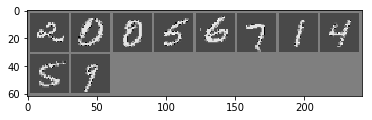

In [87]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = list(range(10))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [89]:
class Leaf(nn.Module):
    def __init__(self, i_size, o_size, h_size=10):
        super(Leaf, self).__init__()
        self.i2h = nn.Linear(i_size, h_size)
        self.h2o = nn.Linear(h_size, o_size)
        self.soft = nn.LogSoftmax(1)
        self.relu = nn.ReLU()
        self.is_leaf = True

    def forward(self, features):
        out = self.i2h(features)
        out = self.relu(out)
        out = self.h2o(out)
        return self.soft(out)

class Node(nn.Module):
    def __init__(self, i_size, o_size):
        super(Node, self).__init__()
        self.o_size = o_size
        self.i_size = i_size
        self.i2o = nn.Linear(i_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.is_leaf = False
    
    def build_tree(self, depth):
        if depth > 0:
            self.left = Node(self.i_size, self.o_size)
            self.right = Node(self.i_size, self.o_size)
            self.left.build_tree(depth - 1)
            self.right.build_tree(depth - 1)
        else:
            self.left = Leaf(self.i_size, self.o_size)
            self.right = Leaf(self.i_size, self.o_size)

    def forward(self, features):
        pr = self.sigmoid(self.i2o(features))
        return pr*self.left(features) + (1 - pr)*self.right(features)

class Tree(nn.Module):
    def __init__(self, i_size, depth):
        self.root = Node(i_size)
        self.root.build_tree(depth)
        cur_node = self.root
        for i in range(depth-1):
            cur_node.add_children()
        self.l1 = Node(i_size)
        self.r1 = Node()

    def forward(self, features):
        out = self.root()


In [ ]:
for batch in 

In [66]:
net = Node(20, 2)

In [67]:
net.build_tree(2)

In [73]:
target = torch.LongTensor([1]*100)

In [74]:
o = net(f)

In [75]:
criterion = nn.NLLLoss()

In [77]:
criterion(o, Variable(target))

Variable containing:
 0.7011
[torch.FloatTensor of size 1]

In [22]:
f = Variable(torch.randn((100, 20)))

In [59]:
l = Leaf(20, 2)

In [60]:
l(f)

Variable containing:
 0.7010  0.2990
 0.4587  0.5413
 0.6445  0.3555
 0.6523  0.3477
 0.5520  0.4480
 0.5729  0.4271
 0.4309  0.5691
 0.6113  0.3887
 0.5364  0.4636
 0.4727  0.5273
 0.5744  0.4256
 0.4254  0.5746
 0.6120  0.3880
 0.3881  0.6119
 0.4329  0.5671
 0.6215  0.3785
 0.5566  0.4434
 0.4899  0.5101
 0.5596  0.4404
 0.4213  0.5787
 0.5454  0.4546
 0.6407  0.3593
 0.7366  0.2634
 0.5357  0.4643
 0.4664  0.5336
 0.4837  0.5163
 0.4695  0.5305
 0.3931  0.6069
 0.4598  0.5402
 0.5820  0.4180
 0.5449  0.4551
 0.5599  0.4401
 0.5203  0.4797
 0.4539  0.5461
 0.4069  0.5931
 0.4765  0.5235
 0.6093  0.3907
 0.5651  0.4349
 0.5195  0.4805
 0.7444  0.2556
 0.4269  0.5731
 0.4473  0.5527
 0.5124  0.4876
 0.4995  0.5005
 0.7357  0.2643
 0.5297  0.4703
 0.5353  0.4647
 0.5564  0.4436
 0.4799  0.5201
 0.4594  0.5406
 0.4223  0.5777
 0.6069  0.3931
 0.5184  0.4816
 0.2934  0.7066
 0.4795  0.5205
 0.4228  0.5772
 0.4746  0.5254
 0.4543  0.5457
 0.4915  0.5085
 0.7506  0.2494
 0.3913  0.6087
 0.

In [58]:
f.shape

torch.Size([100, 20])

In [25]:
n(f)

Variable containing:
 0.5568
 0.4157
 0.6472
 0.5052
 0.7840
 0.5970
 0.5989
 0.6032
 0.5259
 0.4826
 0.5710
 0.3354
 0.6097
 0.2600
 0.4450
 0.4455
 0.6031
 0.4423
 0.6174
 0.5324
 0.4664
 0.6138
 0.3941
 0.4854
 0.3821
 0.5882
 0.6332
 0.6062
 0.2798
 0.4175
 0.4970
 0.4680
 0.4224
 0.5263
 0.3459
 0.3255
 0.5238
 0.5932
 0.4105
 0.5355
 0.6300
 0.5799
 0.5868
 0.6435
 0.6820
 0.3809
 0.5247
 0.5251
 0.4482
 0.5785
 0.3621
 0.5591
 0.4758
 0.3217
 0.5141
 0.3364
 0.6387
 0.6046
 0.4159
 0.6508
 0.2434
 0.4416
 0.7236
 0.2498
 0.3928
 0.5419
 0.6580
 0.4069
 0.4864
 0.5594
 0.5003
 0.4538
 0.4237
 0.4355
 0.4910
 0.4696
 0.6194
 0.6092
 0.5075
 0.5751
 0.5980
 0.5513
 0.3349
 0.5950
 0.4625
 0.4790
 0.5537
 0.3851
 0.6574
 0.5526
 0.3472
 0.4050
 0.5815
 0.3393
 0.3553
 0.2930
 0.1914
 0.4552
 0.1965
 0.5975
[torch.FloatTensor of size 100x1]